<a href="https://colab.research.google.com/drive/1ChqVffx4pOIGXFPEzsCznuHLNceHmQCA?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph langsmith

In [ ]:
!pip install langchain langchain_groq langchain_community

In [ ]:
import os

In [ ]:
from google.colab import userdata
langsmith = userdata.get('langsmith')
groq_api_key = userdata.get('groq_api_key')

In [ ]:
import os
os.environ["LANGCHAIN_API_KEY"]=langsmith
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="LiveLanggraph"

In [ ]:
from langchain_groq import ChatGroq


In [ ]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x797179337220>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x797179337ee0>, model_name='Gemma2-9b-It', groq_api_key=SecretStr('**********'))

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

In [ ]:
from langgraph.graph import StateGraph,START,END

In [ ]:
from langgraph.graph.message import add_messages

In [ ]:
class State(TypedDict):
  # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
  messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [ ]:
def chatbot(state:State):
  return {"messages" : llm.invoke(state["messages"])}

In [ ]:
graph_builder.add_node("chatbot",chatbot)

In [ ]:
graph_builder

In [ ]:
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

In [ ]:
graph = graph_builder.compile()

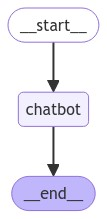

In [ ]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
while True:
  user_input=input("User:")
  if user_input.lower() in["quit","q"]:
    print("Good Bye")
    break
  for event in graph.stream({'messages':("user",user_input)}):
    print(event.values())
    for value in event.values():
      print(value["messages"])
      print("Assistant :", value["messages"].content)

User:hi
dict_values([{'messages': AIMessage(content='Hi! 👋  \n\nHow can I help you today? 😊\n', response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 15, 'total_tokens': 31, 'completion_time': 0.032, 'prompt_time': 0.003190701, 'queue_time': None, 'total_time': 0.035190701}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-353f93a7-17c3-4c81-adca-9d5076bcf65e-0', usage_metadata={'input_tokens': 15, 'output_tokens': 16, 'total_tokens': 31})}])
content='Hi! 👋  \n\nHow can I help you today? 😊\n' response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 15, 'total_tokens': 31, 'completion_time': 0.032, 'prompt_time': 0.003190701, 'queue_time': None, 'total_time': 0.035190701}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-353f93a7-17c3-4c81-adca-9d5076bcf65e-0' usage_metadata={'input_tokens': 15, 'output_

In [ ]:
## Graph With Multiple Nodes
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


In [ ]:
!pip install arxiv wikipedia

In [ ]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
wiki.invoke("What is MAchine LEarning?")
#

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and gen'

In [ ]:
tools=[wiki,arxiv]

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm_with_tools=llm.bind_tools(tools=tools)

In [ ]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}



In [ ]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")
#graph_builder.add_edge("chatbot", END)




In [ ]:
graph = graph_builder.compile()

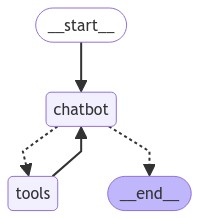

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input = "Hi there! My name is sachin."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is sachin.
================================== Ai Message ==================================

Hello Sachin! Nice to meet you.


In [ ]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_mgfn)
 Call ID: call_mgfn
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent to human preferences. It i
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent to human preferences.  It involves training an agent using feedback provided by humans.  This feedback can be in the form of rewards or penalties, which are used to guide the agent's learning process.
